 # Plots for 'Data over the Kamb channel'
 
 ## Plan

1. overview map
2. REMA splodge
3. ApRES plot
4. radar map
3. icesat2 dots
4. a. Icesat2 crosssection lower
4. b. Icesat2 crosssection raise
5. a. Icesat1 and REMA crossections
5. b. other icesat1 and REMA

In [1]:
import rasterio as rio
import rasterio.mask
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr
from shapely.geometry import Point, LineString, box
import hvplot.xarray  # noqa
import cartopy.crs as crs
import hvplot.pandas
import tarfile

In [2]:
with rio.open('/Users/home/whitefar/DATA/REMOTE_SENSING/MODIS-MOA/moa_mediumlarge_field_area.tif') as image:
    extent_moa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_moa = image.read(1)/100

In [3]:
REMA_bullseye = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/melt_area_REMA.shp').iloc[0].geometry.exterior.coords.xy

In [4]:
#APRES
df = pd.read_csv('/Users/home/whitefar/CODE/apres/KIS2_ApresResults.csv')
df = df.sort_values('x')
points = [Point(xy) for xy in zip(df.x,df.y) ]
apres_gdf = gpd.GeoDataFrame(df,geometry=points,crs=3031)
del df, points

In [5]:
radarlines_paths = sorted(glob.glob("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/*.shp"))
toremove = ['/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line0KIS1.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line0bKIS1.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/lineseis34.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1011.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1213.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1415.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line9.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right1112.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right13.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right1314.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right910.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line10.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line11.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line12.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line13.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line14.shp',]                        
for i in toremove:
    radarlines_paths.remove(i)

radarlines = [gpd.read_file(radarline) for radarline in radarlines_paths]

In [6]:
#/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ds_subset_kamb.nc
icesat2_df = xr.open_dataset("/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ds_subset_kamb_20200404.nc", engine="h5netcdf").drop_dims(['poly_exponent_x','poly_exponent_y']).to_dataframe().query("x > -382064.5722209641 & x < -374781.1654740692 & y > -734075.0820404041 & y < -722764.4514729496 & cycle_number == 3")

In [7]:
icesat1_path = "/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/shapefiles_of_icesat1_over_channel/"
icesat1_gdf = pd.concat([gpd.read_file(icesat1_path+"track0099smoothpoints.shp"),
                         gpd.read_file(icesat1_path+"track0211smoothpoints.shp") ] )

In [8]:
reference_line =  gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/SHARE_SHAPEFILES/interpolated_channel_mid.shp')

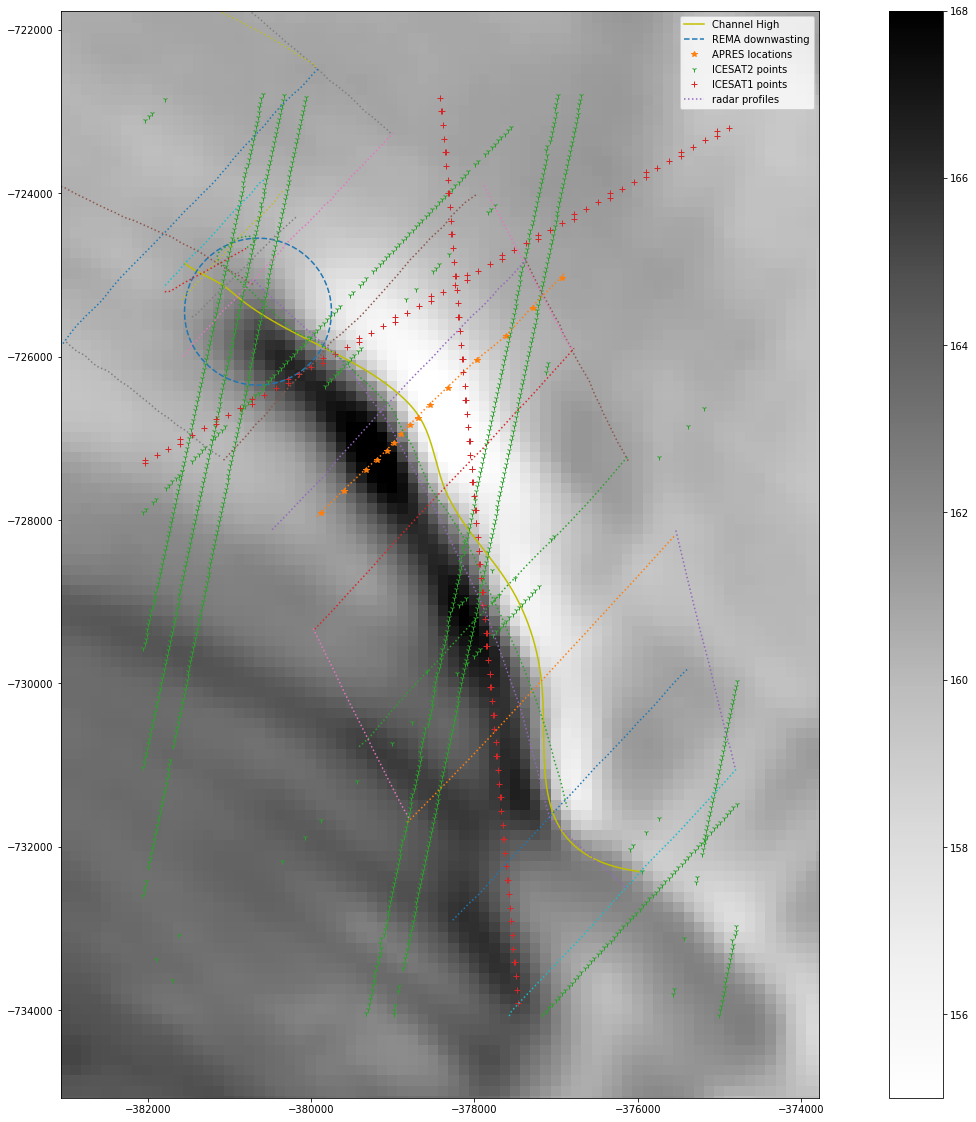

In [9]:
extend_by = 1000

plt.figure(figsize=[25,20])
plt.imshow(im_moa,extent=extent_moa, vmin=155,vmax=168,cmap='Greys')
plt.plot(reference_line.geometry.x,reference_line.geometry.y,'y-',label='Channel High')
plt.plot(REMA_bullseye[0],REMA_bullseye[1],'--',label='REMA downwasting')
plt.plot(apres_gdf.x,apres_gdf.y,'*',label='APRES locations')
plt.plot(icesat2_df.x,icesat2_df.y,'1',label='ICESAT2 points')
plt.plot(icesat1_gdf.x,icesat1_gdf.y,'+',label='ICESAT1 points')
for i,rl in enumerate(radarlines):
    if i ==0:
        plt.plot(rl.geometry.x,rl.geometry.y,':',label='radar profiles')
    else:
        plt.plot(rl.geometry.x,rl.geometry.y,':')
plt.xlim([-382064 - extend_by, -374781 + extend_by])
plt.ylim([-734075.0820404041 - extend_by,-722764.4514729496 + extend_by]) 
plt.legend()
plt.colorbar()
plt.show()

## Plot with rema in the background instead

In [10]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
# with rio.open(path) as image:
#     im = image.read(1)
#     im[im==-9999] = np.nan
#     im = im / duration
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)/100

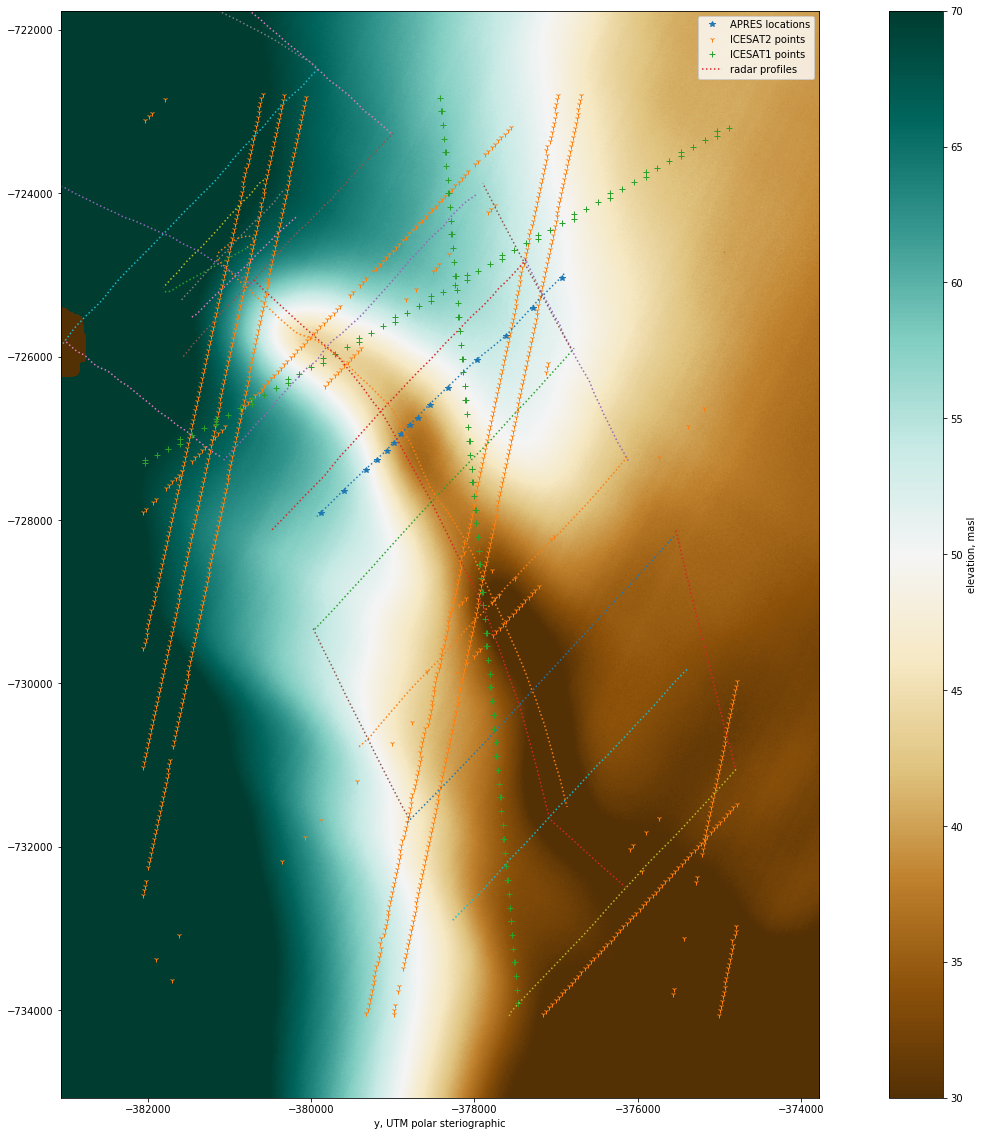

In [11]:
extend_by = 1000

plt.figure(figsize=[25,20])
plt.imshow(im_REMA*100,extent=extent_REMA,vmin=30,vmax=70, cmap='BrBG')
# plt.plot(REMA_bullseye[0],REMA_bullseye[1],'--',label='REMA downwasting')
plt.plot(apres_gdf.x,apres_gdf.y,'*',label='APRES locations')
plt.plot(icesat2_df.x,icesat2_df.y,'1',label='ICESAT2 points')
plt.plot(icesat1_gdf.x,icesat1_gdf.y,'+',label='ICESAT1 points')
for i,rl in enumerate(radarlines):
    if i ==0:
        plt.plot(rl.geometry.x,rl.geometry.y,':',label='radar profiles')
    else:
        plt.plot(rl.geometry.x,rl.geometry.y,':')
plt.xlim([-382064 - extend_by, -374781 + extend_by])
plt.ylim([-734075.0820404041 - extend_by,-722764.4514729496 + extend_by]) 
plt.xlabel('x, UTM polar steriographic')
plt.xlabel('y, UTM polar steriographic')
plt.legend()
cb = plt.colorbar()
cb.set_label('elevation, masl')

plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/geophysics_overview.png')
plt.show()

In [12]:
icesat1_gdf_a.x

NameError: name 'icesat1_gdf_a' is not defined